# Customising intertidal exposure calculations <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_s2ls_intertidal_cyear_3](https://knowledge.dea.ga.gov.au/data/product/dea-intertidal/),
[ga_ls8cls9c_gm_cyear_3](https://explorer.dea.ga.gov.au/products/ga_ls8cls9c_gm_cyear_3)
<!-- * **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook -->


## Background
### Intertidal Exposure

Intertidal coastlines support a wide array of habitats and coastal and marine species.
Low energy tidal flats often support mangrove and seagrass habitats which in turn play host to sea birds, mammals and reptiles. 
Tropical and subtropical intertidal coral reefs provide habitat, food and shelter, soft sediment coastlines support microphytobenthos and intertidal algaes are ubiquitously distributed across Australia.

The combined effects of tide, sun and air make intertidal environments one of the most dynamic places to live on Earth.
Consequently, ecological niches exist within these environments where optimal conditions can be changeable over timescales that range from daily to seasonally and beyond.
Seagrass, coral and algae, for instance, all experience decline in varying combination with exposure and season, level of solar irradiance and air temperature.
Intertidal exposure characteristics and the prevalence of these species in intertidal habitats can further influence the presence and distribution of other intertidal occupying species, such as seabirds and dugongs.
<!-- Seagrass, coral and algae have all been found to decline under conditions of high solar irradiance when combined with air temperature and aerial exposure.
Declines in seagrass biomass are high from summer through to winter while algae dessication and stress occurs when exposure corresponds to coupled high irradiance and high air temperature during warmer months.
Coversely, intertidal corals experience a seasonal mortality risk that peaks in early spring when exposure during seasonally low tides combines high irradiance and low air temperatures. -->

<!-- Temporal differences in intertidal exposure patterns also affect marine fauna in coastal environments.
For instance, seagrass dominated intertidal habitats provide foraging ground for turtles and dugongs.
The daily occurrence of exposure in these environments dictates the time available to these species to forage the nitrogren rich seagrasses of elevated intertidal areas.
Typically, these species forage intertidal areas during night-time high-tides.
Seasonal shifts in the timing of night-time high-tides can significantly influence available foraging times across the year. -->

Intertidal exposure describes the amount of time that intertidal areas are exposed to air from tide coverage.
Leveraging intertidal elevation mapping, the exposure calculation translates high resolution tidal modelling to determine percentage exposure times for intertidal regions, at 10 m<sup>2</sup> resolution.
Exploiting the local influences of tidal harmonic inputs into global tidal modelling, intertidal exposure mapping can tease out exposure patterns over temporal scales such as day, night or season.

Mapping the exposure dynamics of intertidal areas and contrasting their patterns of change over varying timescales supports our ability to further characterise and understand intertidal habitats.
Supporting a vast array of important marine species, it also offers insights into how exposure patterns influence species behaviours and distributions over short to long timescales.


## Description

This notebook outlines the general methodology required to calculate intertidal exposure and demonstrates how tailored calculations can be used to investigate specific temporal influences on exposure times in intertidal ecosystems.

In this notebook, users will:
1. Use a conceptual model to understand how the intertidal exposure calculation is derived
2. Through the use of case studies in a given area of interest, calculate:

    - Full exposure characteristics
    - Seasonally filtered exposure characteristics
    - Combined seasonal and daily exposure characteristics
    - Inverted exposure to calculate monthly, night time inundation characteristics
***

### Introduction to the Intertidal Exposure calculation method

DEA Intertidal Exposure models the percentage of time that any intertidal pixel of known elevation is exposed from tidal inundation. 
Exposure is calculated by comparing the pixel elevation back against a high temporal resolution model of tide heights for that location, based on an ensemble tidal modelling approach. 
Exposure percentage is calculated as the fraction of tidally exposed observations (those lower than the target elevation) relative to the total number of tide model observations, generated for the 3-year product epoch.

This is demonstrated in the figure below where panel *a* shows the digital elevation model, produced for the three year epoch spanning 2016 for Carnot Bay in Western Australia.
A high temporal resolution tide model was generated at 30 minute intervals for the same temporal epoch (panel b).
Intertidal exposure (panel c) is calculated from the cumulative percentile distribution (panel d) of modelled tide heights (panel b).
For any intertidal elevation in the area of interest, the percentile distribution of modelled tide heights equates to the fraction of all modelled tide heights that were exposed during the modelled epoch.
Using the percentile of modelled tide heights (panel d) as a proxy for time, 
<p style="text-align: center;"> Exposure <sub>Elevation z</sub> = Tide  height  percentile * 100 %</p>
In panel d, this is demonstrated by the grey-dashed line, where
<p style="text-align: center;"> Exposure <sub>-1.0 msl</sub> =0.3 * 100 = 30 %</p>
In other words, 30 % of tide heights, modelled at 30 min intervals between 1 Jan 2015 and 31 Dec 2017 (panel b), occur at or below intertidal elevations of -1.0 msl, meaning this elevation is exposed from inundation for 30 % of the modelled time period.


<img src="https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/How_to_guides/Conceptual_model.png?_xsrf=MnwxOjB8MTA6MTcyMjIwOTI0NXw1Ol94c3JmfDEzMjpaamRoWkRkaE5tVmpNV0UzTkRjNU1EbGhOak5tT0daaU9XRmhaR0l4TjJNNllUTmxaVFl3TVRWaFpqQmhNams0TkRrM016azRaR0ZtTUdSall6ZGpPRFV5WldVM01tVTRNamt5TnpjNVl6VXpaVGt6WXpZNU5qUTJaVFl6T0dZM01nPT18ZmYyYmUxZTNmNTQ5NzRiODUxNGI0MmQzNzQ2ZTM0MTUxMjY5OGNkZTFlNjI1NDg2ZjQ1YmJiNTBjNTJlYjZjZQ" width="700" style="display: block; margin: auto;"/>

### Custom filtering of the Intertidal Exposure calculation

In addition to modelling exposure for a full time period, the exposure algorithm supports filtering of selected time periods from within the epoch.
This enables the exploration of exposure dynamics across a range of custom time periods, including day, night, month and season as well as combinations of time periods, e.g. Daytime-Summer exposure.
Users should note that the exposure calculation is performed against a single all-epoch time elevation model of the area of interest.

The animated figure below demonstrates the effect on exposure (panel a) of filtering time periods of interest from within the tidal model (panel b) on the resultant percentile tide height curve (panel c).
Temporal filtering of the exposure model exploits natural changes in the local tide model, influenced by tidal harmonics, local bathymetry and the relative position of the Earth to the moon and sun.
The effect of temporal filtering on the exposure maps (panel a) is most pronounced at the upper and lower ends of the modelled tide height range (panel c).
Local tide modelling varies widely across Australian coastlines and so the impact of these end-member influences will vary vastly with location.
Discussed further below, satellite biases in high and low tide image acquisition for some locations may also produce gaps in the modelling of intertidal elevation as well as exposure at these extreme ends of the tide range.


<img src="https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/How_to_guides/Filter_animation_temporal.gif?_xsrf=MnwxOjB8MTA6MTcyMjIwOTI0NXw1Ol94c3JmfDEzMjpaamRoWkRkaE5tVmpNV0UzTkRjNU1EbGhOak5tT0daaU9XRmhaR0l4TjJNNllUTmxaVFl3TVRWaFpqQmhNams0TkRrM016azRaR0ZtTUdSall6ZGpPRFV5WldVM01tVTRNamt5TnpjNVl6VXpaVGt6WXpZNU5qUTJaVFl6T0dZM01nPT18ZmYyYmUxZTNmNTQ5NzRiODUxNGI0MmQzNzQ2ZTM0MTUxMjY5OGNkZTFlNjI1NDg2ZjQ1YmJiNTBjNTJlYjZjZQ" width="1050" style="display: block; margin: auto;"/>

<!-- ![image](https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/How_to_guides/Filter_animation_temporal.gif?_xsrf=MnwxOjB8MTA6MTcyMjIwOTI0NXw1Ol94c3JmfDEzMjpaamRoWkRkaE5tVmpNV0UzTkRjNU1EbGhOak5tT0daaU9XRmhaR0l4TjJNNllUTmxaVFl3TVRWaFpqQmhNams0TkRrM016azRaR0ZtTUdSall6ZGpPRFV5WldVM01tVTRNamt5TnpjNVl6VXpaVGt6WXpZNU5qUTJaVFl6T0dZM01nPT18ZmYyYmUxZTNmNTQ5NzRiODUxNGI0MmQzNzQ2ZTM0MTUxMjY5OGNkZTFlNjI1NDg2ZjQ1YmJiNTBjNTJlYjZjZQ) -->

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.
Using the "Run" menu at the top of the page, select "Run All Cells".

To edit this analysis for your own area of interest, update the parameters in the "Analysis parameters" cell below.
You'll need to rename the `study_area` parameter and replace the `x` and `y` coordinate pairs for the diagonally opposite latitude and longitude pairs of your area of interest.
To find your coordinates, we recommend using [DEA Maps](https://maps.dea.ga.gov.au).
To change the annual summary views, look out for documented directions to update the `time` parameter throughout the analysis.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
# cd ../..
%cd /home/jovyan/dea_intertidal/dea-intertidal

/home/jovyan/dea_intertidal/dea-intertidal


In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import datacube
import cmocean
import glob
import numpy as np
import xarray as xr
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython import display
from IPython.core.display import Video
from ipywidgets import Output, GridspecLayout

import odc.geo.xr
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from dea_tools.plotting import display_map, xr_animation, rgb

from intertidal.exposure import exposure

### Connect to the DEA datacube

Connect to the DEA database. The `app` parameter is unique to the analysis in this notebook.

In [4]:
# Connect to the datacube to access DEA data.
dc = datacube.Datacube(app='Customising_Intertidal_Exposure')

## Load Data
The following cells will:
* connect to the DEA datacube,
* identify and show the analysis parameters, 
* load satellite and intertidal data and 
* plot the outputs

The default area of interest for this analysis is Queensland's Smithburne River mouth which flows into the eastern side of the Gulf of Carpentaria via a growing recurved spit.
Its vast and dynamic intertidal area forms part of the extensive East Asian-Australasian Flyway for migratory seabirds in the Gulf of Carpentaria.
Recognised as a wetland of national significance, it is also a region that hosts significant patches of seagrass and supports a wide variety of marine fauna populations in the Gulf.

### Analysis parameters

The Smithburne River is used here to demonstrate how various calculations of intertidal exposure can reveal insights into intertidal environments.
Once you have run this notebook through start to finish, try editing the study area and coordinates in the cell below to explore your own small area of interest.

* `study_area` : Location name (e.g. `"Gladstone_Harbour"`). A name for your area of interest, used to name the exported data files at the end of the analysis
* `query_params` : Parameters to define the total area and period of interest
    * `y` : Latitude coordinates (e.g. `(-23.74437, -23.78851)`). Decimal degree coordinates for the diagonnally opposite corners of your area of interest
    * `x` : Longitude coordinates (e.g. `(151.24299, 151.32091)`). Decimal degree coordinates for the diagonnally opposite corners of your area of interest (corresponding to corners used for `y`)
    * `time` : Analysis period (e.g. `("2016", "2022")`). A single year or pair of years between which, all `DEA Intertidal` datasets will be returned. Note: data can only be requested annually from 2016 onwards.

In [25]:
# Identify your area of interest as degree lat/lon coordinates as well
# your nominated time period as start and end dates. Default times
# range from "2016" to "2022"
study_area = "Smithburne_River_Qld" 
query_params = dict(y=(-17.05121, -17.10617),
                    x=(140.90808, 140.97289),
                    time=("2016", "2022"))

# View the area of interest over a generic basemap. Data will be loaded
# inside the red bounding box.
display_map(x=query_params["x"], y=query_params["y"])

In [26]:
# Load DEA Intertidal for the area of interest, and mask out invalid
# nodata values
ds = dc.load(product="ga_s2ls_intertidal_cyear_3", **query_params)
ds = mask_invalid_data(ds)

# Load the blended Landsat 8/9 annual geomedian image for
# the area of interest, and mask out invalid nodata values
geomad_ds = dc.load(
    product="ga_ls8cls9c_gm_cyear_3",
    measurements=["nbart_red", "nbart_green", "nbart_blue"],
    resampling="cubic",
    like=ds,
)
geomad_ds = mask_invalid_data(geomad_ds)

# Add the geomad data layers into the master dataset
ds['red'] = geomad_ds['nbart_red']
ds['green'] = geomad_ds['nbart_green']
ds['blue'] = geomad_ds['nbart_blue']

# Inspect the combined DEA Intertidal and Geomad dataset
ds

<xarray.Dataset> Size: 333MB
Dimensions:                (time: 7, y: 739, x: 1072)
Coordinates:
  * time                   (time) datetime64[ns] 56B 2016-07-01T23:59:59.9999...
  * y                      (y) float64 6kB -3.137e+06 -3.137e+06 ... -3.144e+06
  * x                      (x) float64 9kB 2.078e+06 2.078e+06 ... 2.089e+06
    spatial_ref            int32 4B 3577
Data variables: (12/15)
    elevation              (time, y, x) float32 22MB nan nan nan ... nan nan nan
    elevation_uncertainty  (time, y, x) float32 22MB nan nan nan ... nan nan nan
    exposure               (time, y, x) float32 22MB nan nan nan ... nan nan nan
    ta_hat                 (time, y, x) float32 22MB 1.223 1.224 ... 1.264 1.264
    ta_hot                 (time, y, x) float32 22MB 1.164 1.164 ... 1.202 1.202
    ta_lot                 (time, y, x) float32 22MB -0.7108 -0.7111 ... -0.6991
    ...                     ...
    ta_spread              (time, y, x) float32 22MB 84.0 84.0 ... 85.0 85.0
    qa_ndwi_corr           (time, y, x) float32 22MB nan nan nan ... nan nan nan
    qa_ndwi_freq           (time, y, x) float32 22MB 100.0 100.0 ... 99.0 99.0
    red                    (time, y, x) float32 22MB 123.0 123.0 ... 142.0 142.0
    green                  (time, y, x) float32 22MB 308.0 309.0 ... 366.0 366.0
    blue                   (time, y, x) float32 22MB 393.0 394.0 ... 439.0 438.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Plot and view elevation and exposure for all timesteps

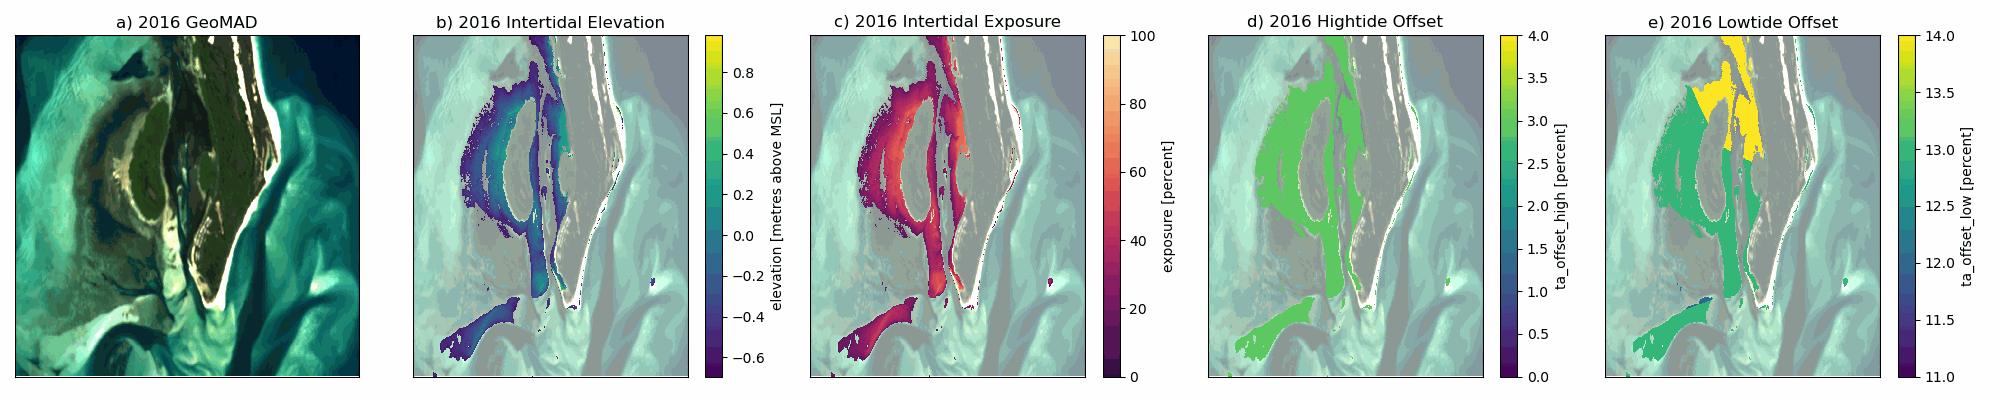

In [27]:
# Plot each epoch and save in preparation to animate the time-series
for date in range(0,len(ds.time -1)):
    
    # Identify a single timestep to inspect
    time = np.datetime_as_string(ds.time.values, unit="Y")[date]
    
    # Setup the figure
    fig, axes = plt.subplots(ncols=5, figsize=(20, 4))

    # Assign the datasets to the figure
    rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=axes[0])

    rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=axes[1], alpha=0.5)
    ds.elevation.sel(time=time).plot(ax=axes[1], cmap="viridis", vmin=ds.elevation.min(), vmax=ds.elevation.max())

    rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=axes[2], alpha=0.5)
    ds.exposure.sel(time=time).plot(ax=axes[2], cmap=cmocean.cm.matter_r, vmin=0, vmax=100)

    rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=axes[3], alpha=0.5)
    ds.ta_offset_high.sel(time=time).where(ds.elevation.sel(time=time).notnull()).plot(ax=axes[3],vmin=ds.ta_offset_high.min(),vmax=ds.ta_offset_high.max())

    rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=axes[4], alpha=0.5)
    ds.ta_offset_low.sel(time=time).where(ds.elevation.sel(time=time).notnull()).plot(ax=axes[4],vmin=ds.ta_offset_low.min(),vmax=ds.ta_offset_low.max())

    labels = [
              f"a) {time} GeoMAD",
              f"b) {time} Intertidal Elevation",
              f"c) {time} Intertidal Exposure",
              f"d) {time} Hightide Offset",
              f"e) {time} Lowtide Offset"
             ]

    for ax, title in zip(axes.reshape(-1), labels):
        ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
        ax.set(xlabel=None, ylabel=None)
        ax.set_title(title)

    plt.tight_layout()
    plt.savefig(f'{time}_DEA_Intertidal.png')
    plt.close()
    
# Animate as a gif and view the time-series

# List of images to include in the gif
path = '/home/jovyan/dea_intertidal/dea-intertidal'
image_files = glob.glob(f'{path}/*_DEA_Intertidal.png')
image_files.sort()

# Output path
gif_path = 'animated.gif'
# Set the frames per second
fps = 1
# Append each epoch-year as a frame to the gif output
with imageio.get_writer(gif_path, mode='I', fps=fps, loop=0) as writer:
    for file in image_files:
        image = imageio.imread(file)
        writer.append_data(image)
# View the epoch-time gif        
Image(gif_path)

### Interpretation

The default Smithburne River, QLD, location is located on the eastern banks of Australia's Gulf of Carpentaria.
A recurved sand spit in this area has been developing over recent decades and is being stabilised by the development of mangrove forest and seagrass tidal flat.
The animation above shows annual changes to intertidal area between 2016 and 2022.
Panel *a* shows the location in satellite imagery.
Note that the annual median imagery shows approximately median tide levels, disguising much of the intertidal area.

Panels *b-e* represent some of the intertidal features mapped annually for this location in the DEA Intertidal dataset suite.
The intertidal digital elevation model in panel *b* demonstrates a tide range within approximately +/- 1.5 m above mean sea level.
This elevation model is a primary input into the intertidal exposure model (panel c).

Intertidal exposure values represent the percentage of time during the epoch that every 10 m<sup>2</sup> pixel was exposed to the air. 
Although this location appears to represent a fairly complete range of modelled exposure values (%), careful examination shows that extrema values are not captured by this model.
This is because there is an offset in satellite image acquisition that fails to capture tide heights at both ends of the tidal spectrum (panels d,e) which gets reflected in the exposure model.
Panels *d-e* show that satellites failed to image this location during the top 3-9 % of high tides (panel d) and during the bottom 0-7 % of low tides (panel e) during the timeseries.
These offsets should be kept in mind when interpreting the spatial outputs of any exposure mapping undertaken using this dataset.

## Temporally Filtered Exposure Calculation

As demonstrated in the [method](#Background), intertidal exposure is calculated by comparing tide heights from a high temporal resolution tide model to an intertidal digital elevation model.
By filtering out time-periods of interest from the tide model, customised exposure maps can be generated.
The following case studies explore this application by mapping single and paired temporal filters to explore the influence of seasonality and solar inundation on intertidal exposure.

To customise the exposure calculation using temporal filtering, the following options are provided for input into the `filters` parameter of the exposure function.
Calculation of multiple filters is supported by inputting filters as a list.
Calculation of paired exposure filters is supported by inputting a list of one or more tuples into the `filters_combined` parameter of the exposure function, as demonstrated in the later case studies below.

Filters accepted by the exposure algorithm include:
* Monthly (e.g. 'Jan', 'Feb', 'Mar' etc)
* Austral Season (e.g. 'Summer', 'Autumn', 'Winter' or 'Spring')
* Equatorial Season (e.g. 'Dry' or 'Wet')
* Solar (e.g. 'Daylight' or 'Night')

### Case study 1 - Mapping exposure by season

Seasonality is a useful way to explore habitat dynamics when considering migratory seabirds.
These global travellers migrate from breeding grounds in Siberia and Alaska, through Asia, to Australia to forage, rest and rebuild their energy reserves each year.
Arriving in Australia's north around September, these birds disperse across the country, returning to the north around March where they prepare to return to their Northern Hemisphere breeding grounds each year.

Migratory seabirds rely heavily on intertidal zones.
They are dependent on both the highest elevations to roost and rest and the lowest elevations to forage and feed, preferring best to occupy locations where roosting and foraging grounds are co-located.

This example maps the changing exposure dynamics of intertidal areas by season to investigate its influence on seabird occupation space across the year.

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [02:44<00:00, 32.80s/it]


Returning low resolution tide array
Filtering timesteps for summer
Filtering timesteps for autumn
Filtering timesteps for winter
Filtering timesteps for spring
Calculating unfiltered exposure
Calculating summer exposure
Calculating autumn exposure
Calculating winter exposure
Calculating spring exposure
Mapping seasonal exposure for 2022


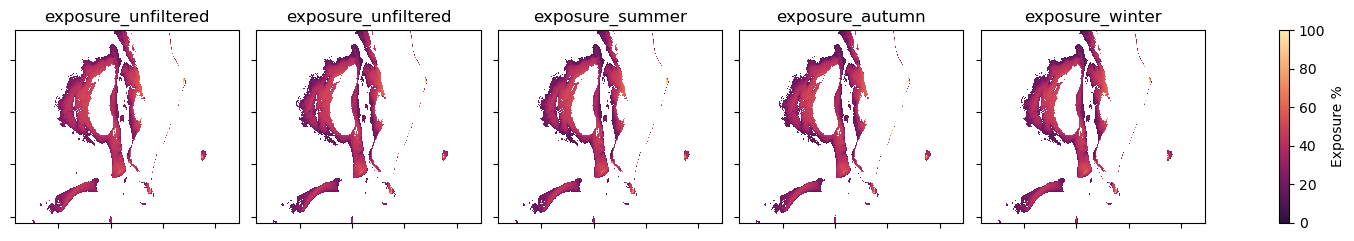

In [28]:
# Change the output year by updating `time = time` to `time = '2016'` for example.
# Default is the latest year in the timeseries.
time = time

# Identify the filters to use to identify datetimes of interest from the high resolution tidal model
filters = ['unfiltered', 'summer', 'autumn', 'winter', 'spring']
filters_combined = None

# Calculate Exposure using the filtered dates of interest
exposure_ds, modelledtides_ds, modelledtides_1d,timeranges, peaks = exposure(
    dem=ds.elevation.sel(time=time),
    start_date=str(np.datetime64(time) - np.timedelta64(1,'Y')),
    end_date=str(np.datetime64(time) + np.timedelta64(1,'Y')),
    modelled_freq = '30 min',
    filters=filters,
    filters_combined=filters_combined,
)

# Add each filtered dataset as a variable in the master dataset 'ds'
for x in list(exposure_ds.keys()):
    ds[f'exposure_{str(x)}']=exposure_ds[str(x)]

# Separate the variables of interest from the master dataset (ds) 
f = ['exposure_unfiltered']
for e in filters:
    f.append('exposure_'+e)

# View seasonal exposure for a single year
print (f'Mapping seasonal exposure for {time}')

fig = ds[f].to_array().sel(time=time).plot(col='variable', cmap=cmocean.cm.matter_r, vmin=0,vmax=100, add_colorbar=False)

for ax,title in zip(fig.axs.flat, f):
    ax.set_title(title)
    ax.label_outer()
    ax.set_xticklabels(labels="")
    ax.set_yticklabels(labels="")
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.add_colorbar(label='Exposure %')

Visual inspection does not notably differentiate these seasonal outputs from one another.

To quantify exposure across the area of interest, sum the number of pixels into exposure 'classes' in the plot below.
For simplicity in the plot, we have designated three classes of exposure.

* Pixels exposed less than 30 % of the time (approximately low-tide areas)
* Pixels exposed between 30 and 70 % of the time (approximately mid-tide areas)
* Pixels exposed more than 70 % of the time (approximately high-tide areas)

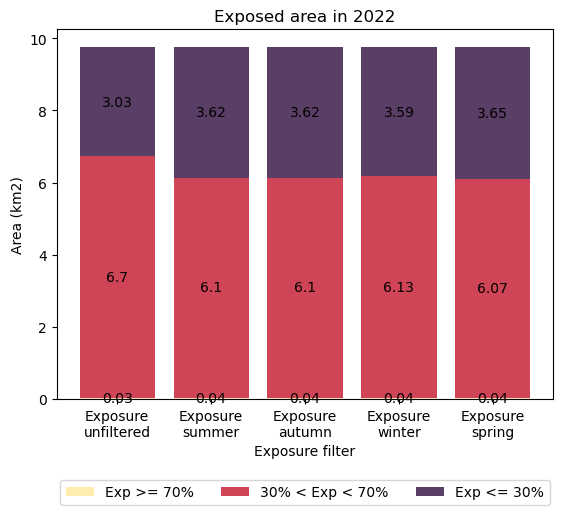

In [29]:
# Explore monthly differences in exposure by area

# Establish some variables to capture the outputs
exp70_100 = []
exp30_70 = []
exp0_30 = []
labels = []
  
# Separate the exposure datasets into categories and count the pixels per category
for x in ds[f].var():
    if 'exp' in x:
        # Prepare the labels for the various exposure datasets        
        if x == 'exposure':
            labels.append(f'Exposure\nUnfiltered')
        if 'exposure_' in x:
            y=x.split('ure_')[-1]
            if '_' in y:
                z=y.split('_')
                labels.append(f'Exposure\n{z[0]}\n{z[-1]}')
            else:
                labels.append(f'Exposure\n{y}')
        # Count the number of pixels exposed between 0 and 100 % of filtered time
        a=ds[str(x)].sel(time=time).count(dim=("x","y")).values
        # Count the number of pixels exposed between 0 and 70 % of filtered time
        b=ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) < 70).count(dim=("x","y")).values
        # Count the number of pixels exposed between 0 and 30 % of filtered time
        c = ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) <= 30).count(dim=("x","y")).values

        # Calculate the pixel counts in each class and translate 10m2 pixel counts to area in km2
        exp70_100.append(round((a[0]-b[0])*0.0001,2))  
        exp30_70.append(round((b[0]-c[0])*0.0001,2))
        exp0_30.append(round((c[0])*0.0001,2))

# Prepare the summary data to plot
exp_counts = {"Exp >= 70%": (np.array(exp70_100)),
              "30% < Exp < 70%": (np.array(exp30_70)),
              "Exp <= 30%": np.array(exp0_30)}
# Set the y-axis minimum for this stacked bar chart
bottom = np.zeros(5)
# Set the bar width
width = 0.8
# Set the colour scheme
cmap = cmocean.cm.matter_r
# Prepare the figure
fig, ax = plt.subplots()

# Plot the summary datasets on a stacked bar chart.
for var, counts in exp_counts.items():
    
    # Set the colour and transparency for each bar
    if var == list(exp_counts.keys())[0]:
        color=cmap(1.0)
        alpha=1
    if var == list(exp_counts.keys())[1]:
        color=cmap(0.5)
        alpha=1
    if var == list(exp_counts.keys())[2]:
        color=cmap(0)
        alpha=0.8
    # Add the bar to the plot
    p = ax.bar(labels, counts, width, label=var, bottom=bottom,color=color, alpha=alpha)
    # Prepare to stack the next bar
    bottom += counts
    # Label each bar with its contribution to the total area
    ax.bar_label(p, label_type='center')

# Prepare the legend
ax.legend(loc="upper center",
             ncol=3,
             bbox_to_anchor=(0.5, -0.2),
             frameon=True)

# Prepare the labels
ax.set_ylabel("Area (km2)")
ax.set_xlabel("Exposure filter")

# Set the figure subtitle
ax.set_title(f"Exposed area in {time}")

plt.show()

#### Interpretation

Compared to the all-epoch exposure map, seasonal maps of exposure for this epoch at Smithburne River were not particularly revealing - though slight differences were discernible.
Assuming the trends are representative of the greater region, this areal bar-chart summary of exposure class extent demonstrates why this area forms part of the important staging grounds for seabird arrivals and departures in Australia.

When migratory seabirds arrive during the Austral spring, they are hungry and energy-depleted.
When they depart during Autumn, they are stock piling energy reserves for their return-migration to their breeding grounds.
In both cases, they are looking to arrive in a location with access to large tidal flats with accessibility during low tide.
At this location, the largest proportions of low tide foraging grounds (exposed less than 30 % of the time) were available during the spring and autumn.
Coincidentally, the smallest proportion of low tide foraging ground was available during the Austral summer which may be a contributing factor to the continuing of seabird migrations across southern Australia during the warmer months.

Similarly, high tide areas for roosting (exposed for more than 70 % of the time) were also slightly greater during the spring and autumn months.

### Case study 2 - Mapping daily exposure by season

In many locations, tidal harmonics, by their very nature, cause differences in absolute day and night time tide heights.
Seasonality and the position of the Earth relative to the sun and moon is also a major influence on these diurnal changes in tide height.

This case study uses paired seasonal with daytime filtering of intertidal exposure to explore how intertidal habitats vary across the year.
Contextually, intertidal photosynthesisers such as corals (zooxanthellae), seagrasses and algae are all sensitive to the combined effects of solar irradiation and aerial exposure. 
Paired with annual growing patterns that vary by season, comparing intertidal daytime, seasonal exposure dynamics reveals important insights into the condition and carrying capacities of intertidal habitats across any given year.

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [02:39<00:00, 31.99s/it]


Returning low resolution tide array
Filtering timesteps for daylight
Filtering timesteps for summer
Filtering timesteps for autumn
Filtering timesteps for winter
Filtering timesteps for spring
Calculating unfiltered exposure
Calculating daylight exposure
Calculating summer exposure
Calculating autumn exposure
Calculating winter exposure
Calculating spring exposure
Calculating daylight_summer exposure
Calculating daylight_autumn exposure
Calculating daylight_winter exposure
Calculating daylight_spring exposure
Mapping seasonal exposure for 2022


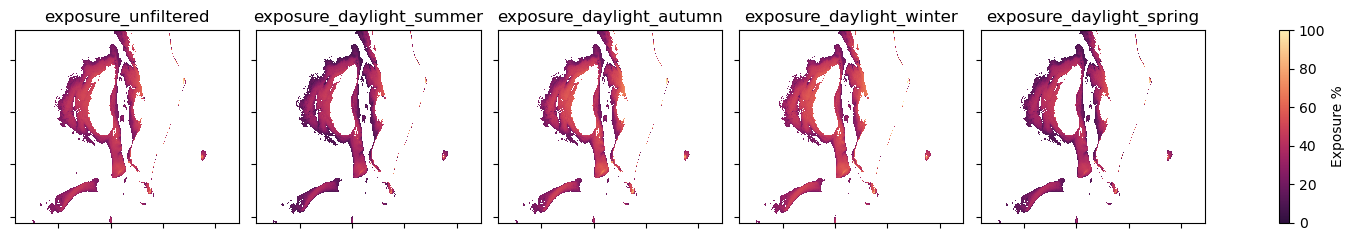

In [30]:
# Set the year to update data outputs by changing `time = time` to `time = '2016'` for example
time = time

# Identify the paired-filters to use to identify datetimes of interest from the high res tidal model
filters = None
filters_combined = [("daylight","summer"),("daylight","autumn"),("daylight","winter"),("daylight","spring")]

# Use the default settings to calculate a high temporal resolution tide model and
# filter out the nominated datetimes to calculate exposure. Default settings
# include a tide model frequency of 30 minutes
exposure_ds, modelledtides_ds, modelledtides_1d,timeranges, peaks = exposure(
    dem=ds.elevation.sel(time=time),
    start_date=str(np.datetime64(time) - np.timedelta64(1,'Y')),
    end_date=str(np.datetime64(time) + np.timedelta64(1,'Y')),
    modelled_freq = '30 min',
    filters=filters,
    filters_combined=filters_combined,
)

# Add each filtered dataset as a variable layer in the master dataset 'ds'
for x in list(exposure_ds.keys()):
    ds[f'exposure_{str(x)}']=exposure_ds[str(x)]
    
# Separate from the master dataset (ds) the variables of interest
f = ['exposure_unfiltered']
for e in filters_combined:
    f.append('exposure_'+e[0]+'_'+e[1])

# View the filtered outputs

print (f'Mapping seasonal exposure for {time}')

fig = ds[f].to_array().sel(time=time).plot(col='variable', cmap=cmocean.cm.matter_r, vmin=0,vmax=100, add_colorbar=False)

for ax,title in zip(fig.axs.flat, f):
    ax.set_title(title)
    ax.label_outer()
    ax.set_xticklabels(labels="")
    ax.set_yticklabels(labels="")
    ax.set_xlabel("")
    ax.set_ylabel("")
    
fig.add_colorbar(label='Exposure %')

Visual inspection of these exposure maps shows that there are clear differences in the distribution of daytime-seasonally filtered exposure times across a year.

To quantify the changing areas of daytime exposure with season, we will graph grouped pixel counts as previously, using the same classes, as follows:

* Pixels exposed less than 30 % of the time (approximately low-tide areas)
* Pixels exposed between 30 and 70 % of the time (approximately mid-tide areas)
* Pixels exposed more than 70 % of the time (approximately high-tide areas)

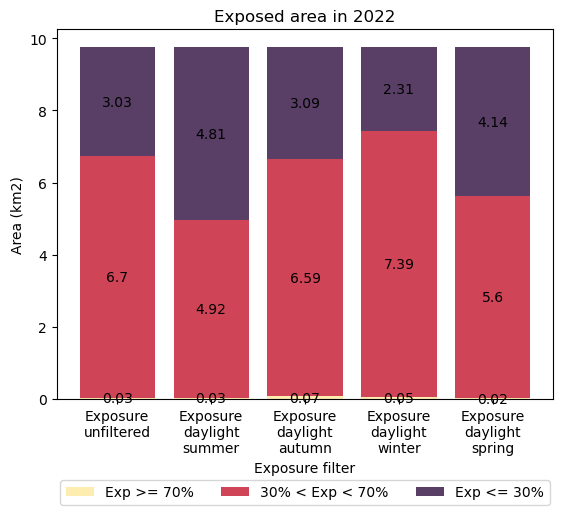

In [31]:
# Establish some variables to capture the outputs
exp70_100 = []
exp30_70 = []
exp0_30 = []
labels = []
    
# Separate the exposure datasets into categories and count the pixels per category
for x in ds[f].var():
    if 'exp' in x:
        # Prepare the labels for the various exposure datasets        
        if x == 'exposure':
            labels.append(f'Exposure\nUnfiltered')
        if 'exposure_' in x:
            y=x.split('ure_')[-1]
            if '_' in y:
                z=y.split('_')
                labels.append(f'Exposure\n{z[0]}\n{z[-1]}')
            else:
                labels.append(f'Exposure\n{y}')
        # Count the number of pixels exposed between 0 and 100 % of filtered time
        a=ds[str(x)].sel(time=time).count(dim=("x","y")).values

        # Count the number of pixels exposed between 0 and 70 % of filtered time
        b=ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) < 70).count(dim=("x","y")).values

        # Count the number of pixels exposed between 0 and 30 % of filtered time
        c = ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) <= 30).count(dim=("x","y")).values

        # Calculate the pixel count contributions to each class and translate 10m2 pixel counts to area as km2
        exp70_100.append(round((a[0]-b[0])*0.0001,2))  
        exp30_70.append(round((b[0]-c[0])*0.0001,2))
        exp0_30.append(round((c[0])*0.0001,2))

# Prepare the summary data to plot

exp_counts = {"Exp >= 70%": (np.array(exp70_100)),#*0.0001,
              "30% < Exp < 70%": (np.array(exp30_70)),#*0.0001,
              "Exp <= 30%": np.array(exp0_30)}#*0.0001}
# Set the y-axis minimum for this stacked bar chart
bottom = np.zeros(5)
# Set the bar width
width = 0.8
# Set the colour scheme
cmap = cmocean.cm.matter_r
# Prepare the figure
fig, ax = plt.subplots()

# Plot the summary datasets on a stacked bar chart.
for var, counts in exp_counts.items():
    
    # Set the colour and transparency for each bar
    if var == list(exp_counts.keys())[0]:
        color=cmap(1.0)
        alpha=1
    if var == list(exp_counts.keys())[1]:
        color=cmap(0.5)
        alpha=1
    if var == list(exp_counts.keys())[2]:
        color=cmap(0)
        alpha=0.8
    # Add the bar to the plot
    p = ax.bar(labels, counts, width, label=var, bottom=bottom,color=color, alpha=alpha)
    # Prepare to stack the next bar
    bottom += counts
    # Label each bar with its contribution to the total area
    ax.bar_label(p, label_type='center')

# Prepare the legend
ax.legend(loc="upper center",
             ncol=3,
             bbox_to_anchor=(0.5, -0.2),
             frameon=True)

# Prepare the labels
ax.set_ylabel("Area (km2)")
ax.set_xlabel("Exposure filter")

# Set the figure subtitle
ax.set_title(f"Exposed area in {time}")

plt.show()

#### Interpretation

Daytime exposure mapping by season reveals the dynamicism of intertidal environments in this location across a given year.

Over the Austral autumn and winter at this location, very little intertidal zone is exposed for more than 70 % of the time (0.31 and 0.38 km<sup>2</sup> respectively).
Additionally, over 3/4 of the total intertidal area experiences exposure for less than 30 % of daylight hours during these cooler seasons.

In the spring and summer seasons, large portions of intertidal area that had low exposure (< 30 %) during the cool seasons has transitioned to having medium exposure (30 < exp < 70 %).
Similarly, significant portions of the cool season medium exposure class have transitioned to the high exposure class (> 70 %) during the warm spring and summer seasons.
Consequently, warmer seasons (spring and summer) see greater proportions of the intertidal area exposed to the sun and air than cooler seasons (autumn and winter).
These same areas are also accustomed to being inundated for long periods during the cooler months.

These modelled exposure estimates align with field observations related to the stress and mortality of organisms in intertidal zones.
For example, [Buckee et al (2022)](https://www.frontiersin.org/journals/marine-science/articles/10.3389/fmars.2022.904191/full) modelled emersion mortality risk in Australian shallow coral reefs and found that across the continent, emersion related coral-mortality risk was generally greatest during the Australian spring time.
Causal mechanisms included combinations of mean sea level minima, high incidence of solar irradiation and low daytime air temperatures coinciding with exposure times.

Similarly, seagrass biomass typically peaks around late spring and begins to decline, with minima observed during winter. 
Seagrass stress and decline was observed to occur in combination with aerial exposure and maximum daily solar irradiances [(e.g. Petrou et al., 2013)](https://www.int-res.com/abstracts/meps/v482/p93-106/). 
Algaes also decline under similar conditions, with the addition of temperature being shown to cause dessication and stress during periods of exposure [(e.g. Yu et al., 2013)](https://www.sciencedirect.com/science/article/abs/pii/S1385110113000440).

Spatial and temporal mapping of exposure helps to characterise one of the major biophysical influences on species distributions in intertidal habitats.
Daytime seasonal exposure mapping is a valuable variable to help explain intertidal species presence and absence across a year.

### Case study 3 - Mapping nightly inundation by month

There is a wide range of temporal filtering options that can be used either singly or paired in the intertidal exposure algorithm.

In this case study, we pair night-time with monthly exposure to develop a different understanding of our study site, additionally converting the values from exposure to inundation.
To translate exposure (% time) to inundation (% time), simply subtract the exposure value from 100 %.
This returns the inverse proportion of modelled tide heights from the cumulative percentile tide-height curve, as demonstrated in the [method](#Background).

Contextually, seagrass dependent foragers, such as dugong, source much of their nutritition from shallow intertidal areas. 
A night-time preference for activity and foraging has been observed in some dugong populations and inundation provides these animals with access to elevated intertidal areas and nutritional sources that deviate from sub-tidal varieties [(e.g. Sheppard et al., 2010](https://onlinelibrary.wiley.com/doi/10.1111/j.1748-7692.2010.00374.x)[, Derville et al., 2022).](https://www.nature.com/articles/s41598-021-04412-3)
By translating exposure to inundation and mapping the monthly night-time distributions of intertidal inundation, insights into the tidal influences on the presence, absence and distribution of nocturnal intertidal foragers is revealed.

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [02:38<00:00, 31.73s/it]


Returning low resolution tide array
Filtering timesteps for night
Filtering timesteps for jan
Filtering timesteps for feb
Filtering timesteps for mar
Filtering timesteps for apr
Filtering timesteps for may
Filtering timesteps for jun
Filtering timesteps for jul
Filtering timesteps for aug
Filtering timesteps for sep
Filtering timesteps for oct
Filtering timesteps for nov
Filtering timesteps for dec
Calculating unfiltered exposure
Calculating night exposure
Calculating jan exposure
Calculating feb exposure
Calculating mar exposure
Calculating apr exposure
Calculating may exposure
Calculating jun exposure
Calculating jul exposure
Calculating aug exposure
Calculating sep exposure
Calculating oct exposure
Calculating nov exposure
Calculating dec exposure
Calculating night_jan exposure
Calculating night_feb exposure
Calculating night_mar exposure
Calculating night_apr exposure
Calculating night_may exposure
Calculating night_jun exposure
Calculating night_jul exposure
Calculating night_aug 

  0%|          | 0/12 (0.0 seconds remaining at ? frames/s)

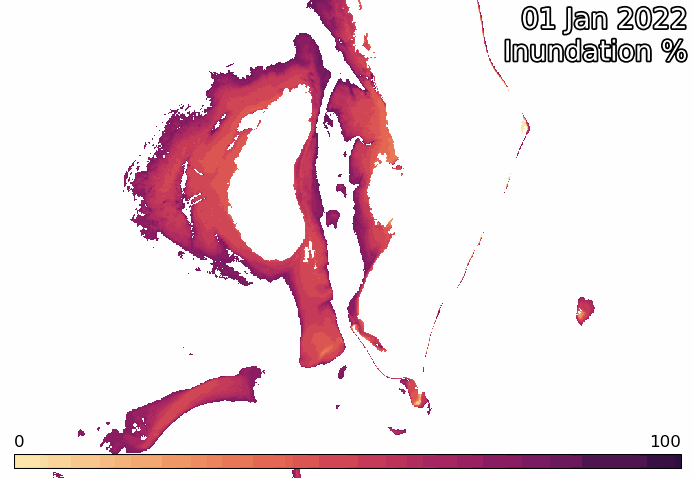

In [32]:
# Set the year to update data outputs by changing `time = time` to `time = '2016'` for example
time = time

# Identify the filters to use to identify datetimes of interest from the high res tidal model
filters = None
filters_combined = [("night","jan"),
                    ("night","feb"),
                    ("night","mar"),
                    ("night","apr"),
                    ("night","may"),
                    ("night","jun"),
                    ("night","jul"),
                    ("night","aug"),
                    ("night","sep"),
                    ("night","oct"),
                    ("night","nov"),
                    ("night","dec")
                   ]

# Model exposure
exposure_ds, modelledtides_ds, modelledtides_1d,timeranges, peaks = exposure(
    dem=ds.elevation.sel(time=time),
    start_date=str(np.datetime64(time) - np.timedelta64(1,'Y')),
    end_date=str(np.datetime64(time) + np.timedelta64(1,'Y')),
    modelled_freq = '30 min',
    filters=filters,
    filters_combined=filters_combined,
)

# Separate from the master dataset (ds) the variables of interest
f = ['exposure_unfiltered']
for e in filters_combined:
    f.append('exposure_'+e[0]+'_'+e[1])
    
# Add each filtered dataset as a variable layer in the master dataset 'ds'
for x in list(exposure_ds.keys()):
    ds[f'exposure_{str(x)}']=exposure_ds[str(x)]#.squeeze(dim='time')

# Calculate the inverse of exposure to convert to inundation 
inundation_ds = 100-exposure_ds

# Separate from the master dataset (ds) the variables of interest
f = ['inundation_unfiltered']
for e in filters_combined:
    f.append('inundation_'+e[0]+'_'+e[1])
    
# Add each filtered dataset as a variable layer in the master dataset 'ds'
for x in list(inundation_ds.keys()):
    ds[f'inundation_{str(x)}']=inundation_ds[str(x)]

# Animate and view the monthly timeseries
# Copy and edit the master dataset
ds2 = ds.sel(time=time)[f].copy(deep=True)
ds2 = ds2.drop_vars(['inundation_unfiltered'])
ds2 = ds2.squeeze('time')

# Reshape the dataset to reset the time dimension for monthly nighttime inundation
variables = [ds2[var].expand_dims('time').assign_coords(time=[var]) for var in ds2.data_vars]
new_ds = xr.concat(variables, dim='time')
ds2 = new_ds.to_dataset()

newtime = []
for x in range(1,13,1):
    if len(str(x)) == 1:
        x = f'0{x}'
    newtime.append(np.datetime64(f'{time}-{x}'))

ds2['time']=newtime

# Animate and view
xr_animation(ds2,
             bands=['inundation_night_jan'],
             output_path = f'night_inundation.gif',
             interval=1000,
             imshow_kwargs={"cmap": cmocean.cm.matter, "vmin": 0, "vmax": 100},
             colorbar_kwargs={"colors": "black"},
             show_text='Inundation %',
             width_pixels=500
            )
plt.close()

# View the monthly, night time inundation gif        
Image('night_inundation.gif')

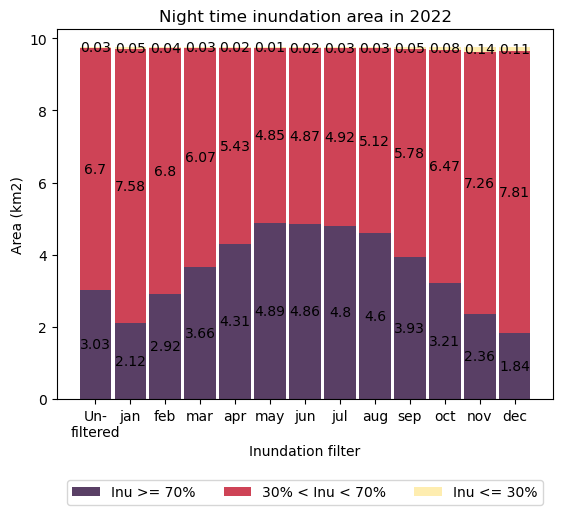

In [33]:
# Establish some variables to capture the outputs
inu70_100 = []
inu30_70 = []
inu0_30 = []
labels = []
   
# Separate the exposure datasets into categories and count the pixels per category
for x in ds[f].var():
    
    # Prepare the labels for the various exposure datasets        
    if x == 'inundation_unfiltered':
        labels.append(f'Un-\nfiltered')
    if 'inundation_night_' in x:
        y=x.split('night_')[-1]
        if '_' in y:
            z=y.split('_')
            labels.append(f'{z[0]}\n{z[-1]}')
        else:
            labels.append(f'{y}')
    # Count the number of pixels exposed between 0 and 100 % of filtered time
    a=ds[str(x)].sel(time=time).count(dim=("x","y")).values

    # Count the number of pixels exposed between 0 and 70 % of filtered time
    b=ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) < 70).count(dim=("x","y")).values

    # Count the number of pixels exposed between 0 and 30 % of filtered time
    c = ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) <= 30).count(dim=("x","y")).values

    # Calculate the pixel count contributions to each class and translate 10m2 pixel counts to area as km2
    inu70_100.append(round((a[0]-b[0])*0.0001,2))  
    inu30_70.append(round((b[0]-c[0])*0.0001,2))
    inu0_30.append(round((c[0])*0.0001,2))

# Prepare the summary data to plot

inu_counts = {"Inu >= 70%": (np.array(inu70_100)),#*0.0001,
              "30% < Inu < 70%": (np.array(inu30_70)),#*0.0001,
              "Inu <= 30%": np.array(inu0_30)}#*0.0001}
# Set the y-axis minimum for this stacked bar chart
bottom = np.zeros(13)
# Set the bar width
width = 0.9
# Set the colour scheme
cmap = cmocean.cm.matter
# Prepare the figure
fig, ax = plt.subplots()

# Plot the summary datasets on a stacked bar chart.
for var, counts in inu_counts.items():
    
    # Set the colour and transparency for each bar
    if var == list(inu_counts.keys())[0]:
        color=cmap(1.0)
        alpha=0.8
    if var == list(inu_counts.keys())[1]:
        color=cmap(0.5)
        alpha=1
    if var == list(inu_counts.keys())[2]:
        color=cmap(0)
        alpha=1
    # Add the bar to the plot
    p = ax.bar(labels, counts, width, label=var, bottom=bottom,color=color, alpha=alpha)
    # Prepare to stack the next bar
    bottom += counts
    # Label each bar with its contribution to the total area
    ax.bar_label(p, label_type='center')

# Prepare the legend
ax.legend(loc="upper center",
             ncol=3,
             bbox_to_anchor=(0.5, -0.2),
             frameon=True)

# Prepare the labels
ax.set_ylabel("Area (km2)")
ax.set_xlabel("Inundation filter")

# Set the figure subtitle
ax.set_title(f"Night time inundation area in {time}")

plt.show()

#### Interpretation

There is a stark pattern in the monthly night-time inundation characteristics of this location.
Between September and January each year, more than half of the intertidal zone is inundated for more than 70 % of night-time.

This seasonality may be influential on relatively poorly understood dugong distributions and life-cycles.
The nutritional content of intertidal seagrass varies with elevation and dugong have been observed to venture inshore at night to forage on varieties only available at high tide [(e.g. Sheppard et al., 2010](https://onlinelibrary.wiley.com/doi/10.1111/j.1748-7692.2010.00374.x)[, Derville et al., 2022).](https://www.nature.com/articles/s41598-021-04412-3)
There is some evidence that dugong herds are larger and less dispersed during spring and summer, when seagrass meadows are large and highly productive [(Lanyon 2003)](https://www.publish.csiro.au/wr/WR98082).
This analysis shows that those meadows are also readily accessible during preferred foraging hours at this time of the year.
Female dugong fertility is correspondingly most active between July and December with calving concentrated around similar months [(Marsh et al., 1984](https://www.researchgate.net/publication/248901675_Breeding_Cycle_Life_History_and_Population_Dynamics_of_the_Dugong_Dugon_dugon_Sirenia_Dugongidae)[; Burgess., 2012)](https://espace.library.uq.edu.au/view/UQ:301919), when nutritious food is abundant and accessible.
Spatial and temporal mapping of exposure characteristics in known dugong habitat reveals that access to nutritious food, in addition to seagrass abundance, is linked to seasonality and may influence the life cycle and reproductive success of the vulnerable dugong species.

Mapping the exposure characteristics of intertidal habitats reveals important insights and influences on the distribution and life-cycles of the species that occupy them.
Exposure time is a critically influential element in intertidal ecosystems and the ability to map it over time and space enables improved understanding of these environments for conservation and management.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** August 2024

**Compatible datacube version:** 

In [34]:
print(datacube.__version__)

1.8.18


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)